In [1]:
import sys 

import cplex
import docplex

from docplex.mp.model import Model 

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import time

In [2]:
def dist(p1, p2):
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** (1/2)

def generate_test(test_size):
    points = np.random.randint(low = 0, high = 80, size =(2, test_size))

    dists = np.zeros((test_size, test_size))

    for i in range(test_size):
        for j in range(test_size):
            dists[i,j] = dist(points[:,i], points[:, j])
                                    
    demands = np.random.randint(low = 3, high = 7, size =(test_size))
    demands[0] = 0

    return points, dists, demands


In [3]:

def real_solve(dists, demands, Vehicles, n_points, max_cap):
    Range = range(n_points)
    VRP = Model(name='VRP')

    x = VRP.binary_var_matrix(Range, Range, name = 'x')
    u = VRP.continuous_var_list(Range, name ='u')

    VRP.minimize(VRP.sum(dists[i,j]*x[i,j] for i in Range for j in Range))

    VRP.add_constraints(x[i,i]==0 for i in Range)

    VRP.add_constraint(VRP.sum(x[0,j] for j in Range) == Vehicles)
    VRP.add_constraint(VRP.sum(x[i,0] for i in Range) == Vehicles)

    VRP.add_constraints(VRP.sum(x[i,j] for j in Range) == 1 for i in range(1,n_points))
    VRP.add_constraints(VRP.sum(x[i,j] for i in Range) == 1 for j in range(1,n_points))

    VRP.add_constraints(u[i] - u[j] + x[i,j] * max_cap <= max_cap - demands[j] for i in range(1,n_points)
                        for j in range(1,n_points))
    VRP.add_constraints(u[i] <= max_cap for i in Range)
    VRP.add_constraints(u[i] >= demands[i] for i in Range)

    VRP.context.solver.log_output = True
    VRP.context.solver.verbose = 5

    VRP.solve()
    VRP.print_solution()
    return model_to_paths(n_points, VRP, x)

def matrix_to_paths(matrix):
    Origin = []
    Destin = []
    n = len(matrix)
    paths = []
    for i in range(n):
        paths.append([0])
        if matrix[0][i]:
            cur = i
            while cur != 0:
                paths.append(cur)
                for k in range(n):
                    if matrix[cur][k]:
                        cur = k
    return paths


def paths_to_matrix(paths):
    n_verts = max(max(path) for path in paths)
    m = [[0] * n_verts for i in range(n_verts)]
    for path in paths:
        for i in range(len(path) - 2):
            matrix[path[i]][path[i + 1]] = 1
    return matrix


In [4]:
def arrow(fig, fr, to, color='black'):
    fig.arrow(fr[0], fr[1], to[0] - fr[0], to[1] - fr[1], fc='black', ec=color, length_includes_head=True, head_width=1)
    
def get_color(n):
    return [int(n) // (256 ** i) % 256 / 256 for i in range(3)]

def generate_n_colors(n):
    return [get_color(c) for c in np.linspace(0xff, 0xAAAFFF, n)]


In [5]:
def model_to_paths(n, model, x):
    paths = []
    for i in range(n):
        # matrix[0][i]
        if model.solution.get_value(x[0, i]): 
            path = [0]
            cur = i
            while cur != 0:
                path.append(cur)
                for k in range(n):
                    # matrix[cur][k]
                    if model.solution.get_value(x[cur, k]):
                        cur = k
                        break
            path.append(0)
            paths.append(path)
    return paths


def paths_to_matrix(paths):
    n_verts = max(max(path) for path in paths) + 1
    matrix = [[0] * n_verts for i in range(n_verts)]
    for path in paths:
        for i in range(len(path) - 2):
            matrix[path[i]][path[i + 1]] = 1
        matrix[path[i + 1]][0] = 1
    return matrix


def matrix_to_paths(matrix):
    n = len(matrix)
    paths = []
    for i in range(n):
        if matrix[0][i]:
            path = [0]
            cur = i
            while cur != 0:
                path.append(cur)
                for k in range(n):
                    if matrix[cur][k]:
                        cur = k
                        break
            path.append(0)
            paths.append(path)
    return paths

def distances(paths, distances):
    n_verts = max(max(path) for path in paths) + 1
    matrix = [[0] * n_verts for i in range(n_verts)]
    res = 0
    for path in paths:
        for i in range(len(path) - 1):
            res += distances[path[i]][path[i + 1]]
    return res


Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 59 rows and 16 columns.
Reduced MIP has 212 rows, 224 columns, and 966 nonzeros.
Reduced MIP has 210 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.58 ticks)
Found incumbent of value 678.596663 after 0.02 sec. (2.12 ticks)
Probing time = 0.00 sec. (0.65 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 212 rows, 224 columns, and 966 nonzeros.
Reduced MIP has 210 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.68 ticks)
Probing time = 0.00 sec. (0.66 ticks)
Clique table members: 119.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (0.46 ticks)

        Nodes                                         Cuts/
   Node  Left     Ob

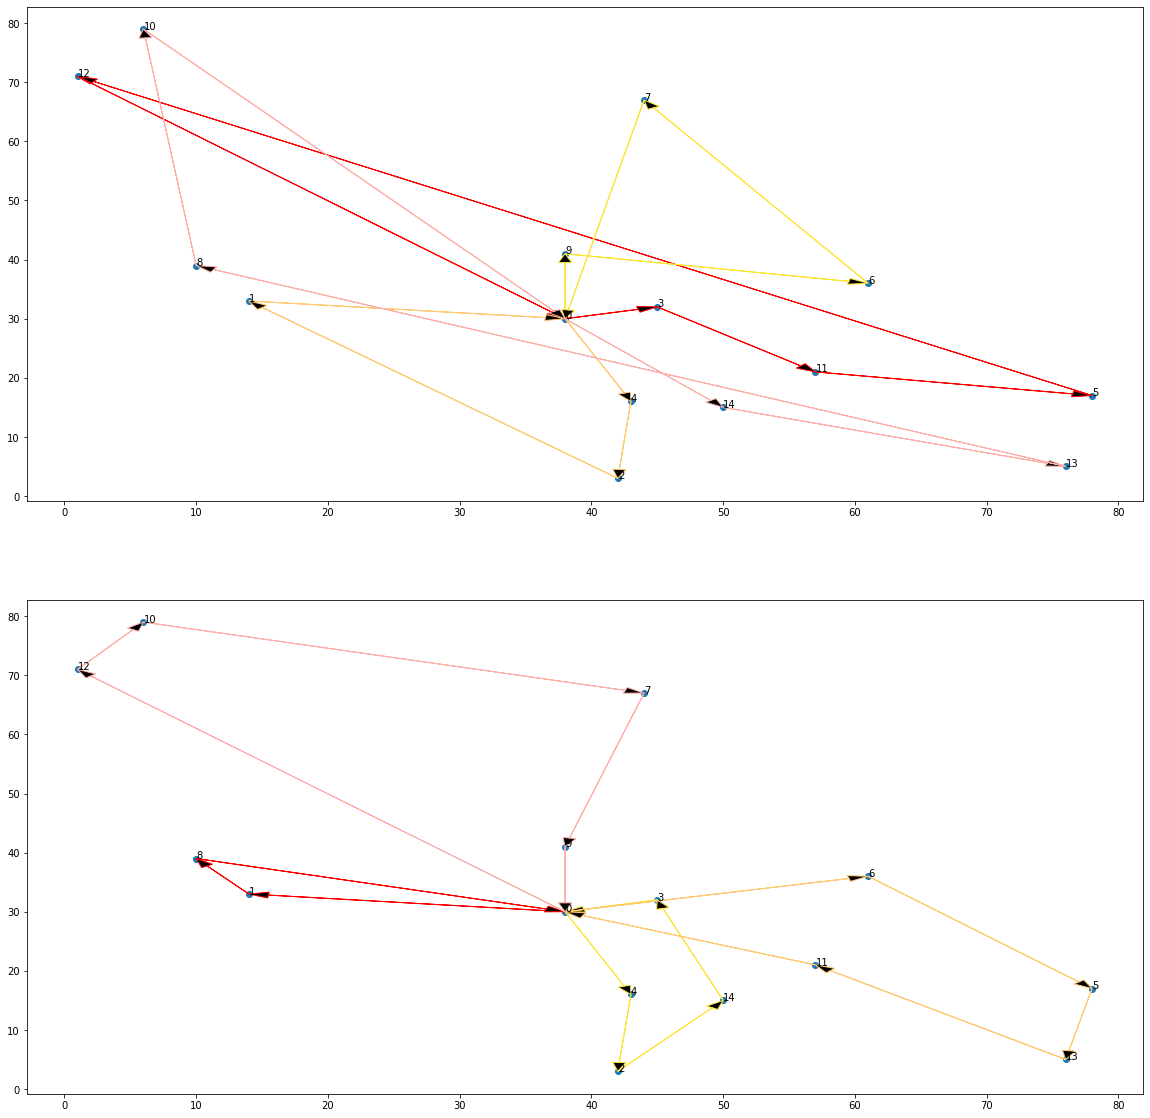

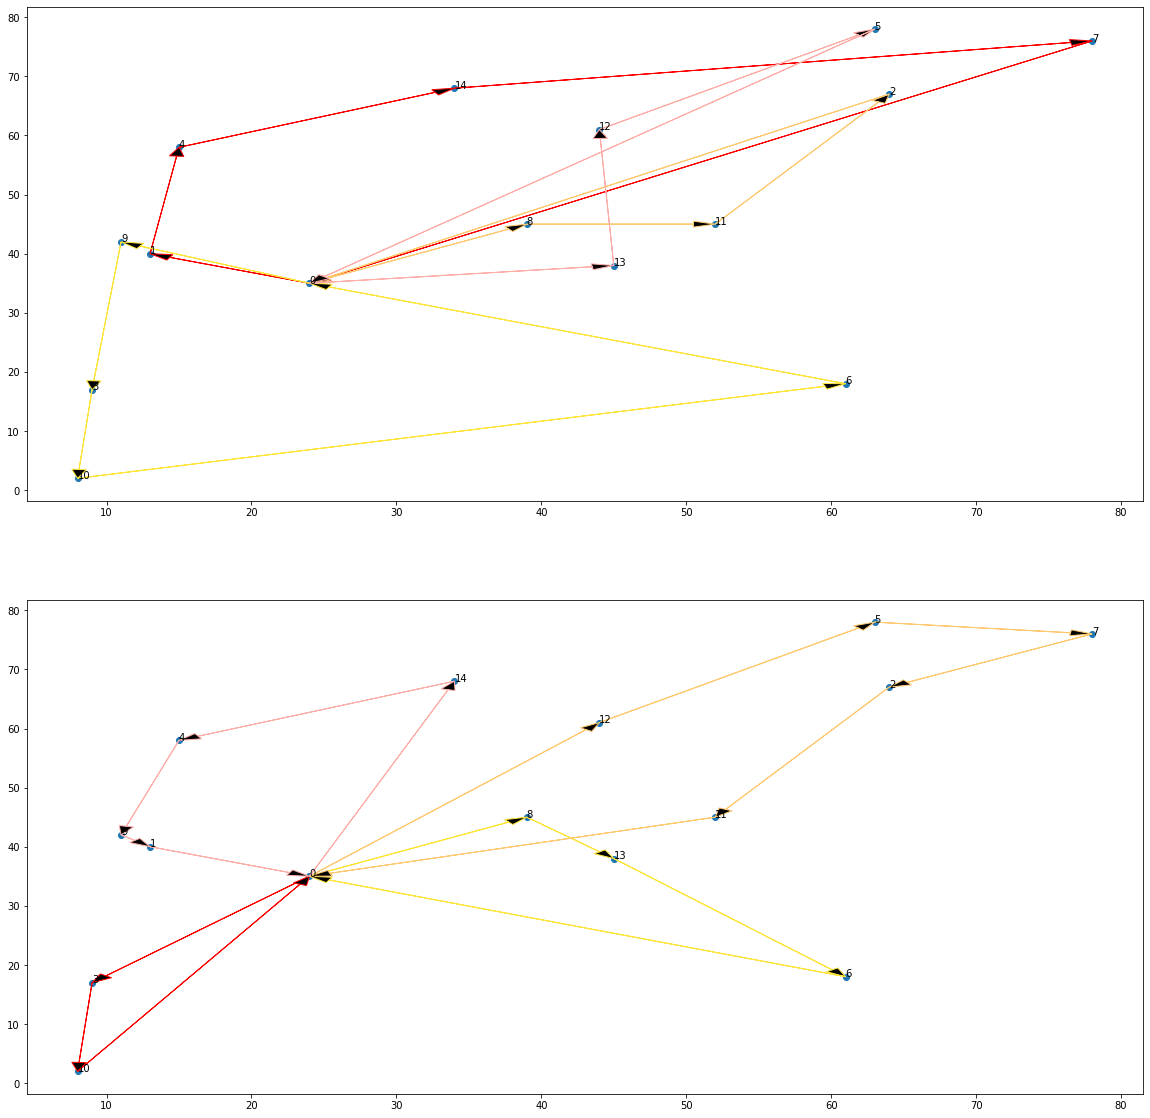

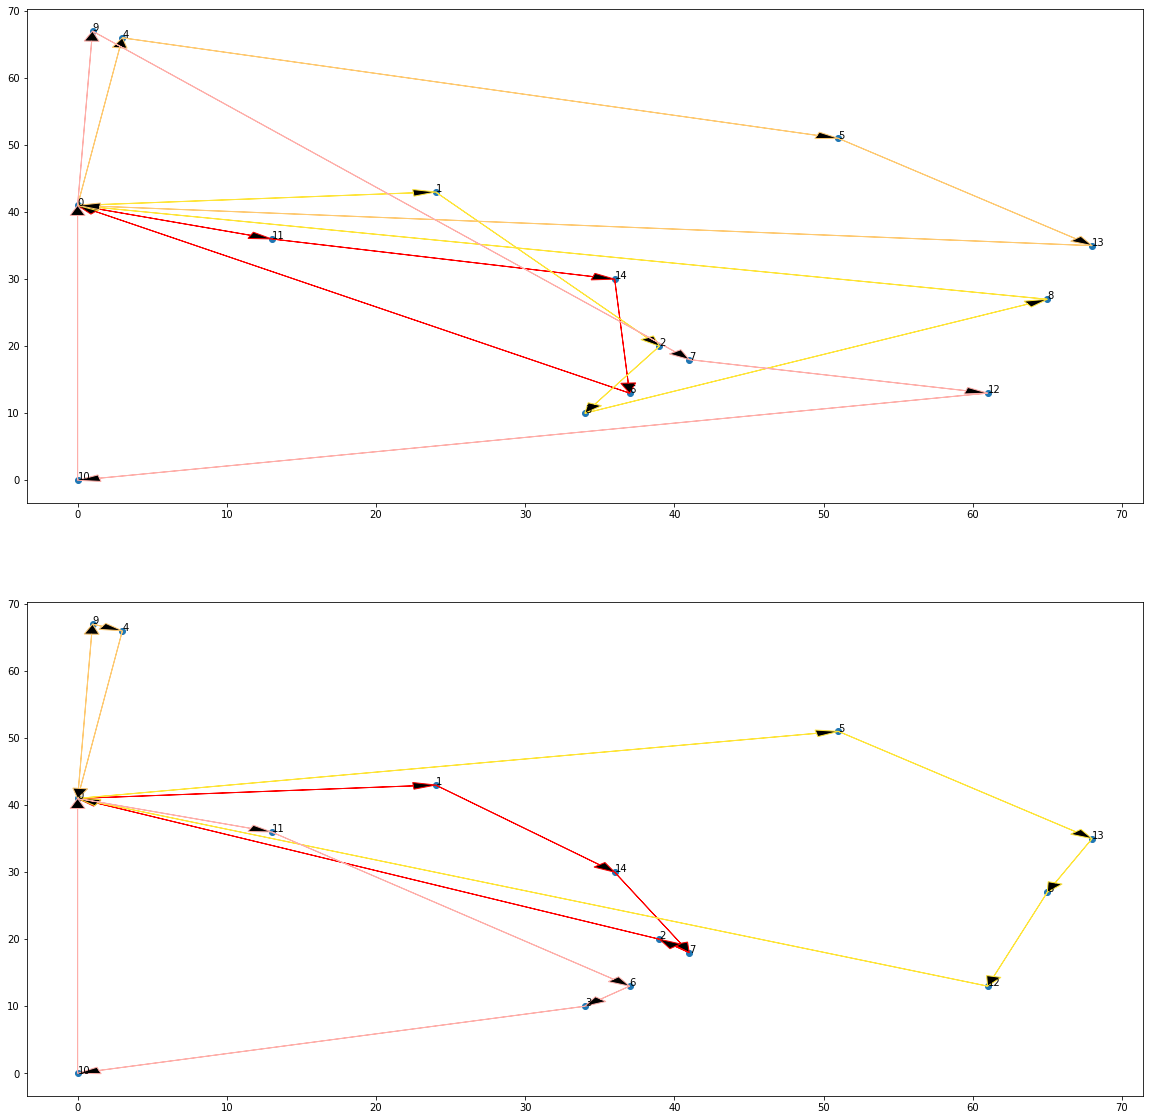

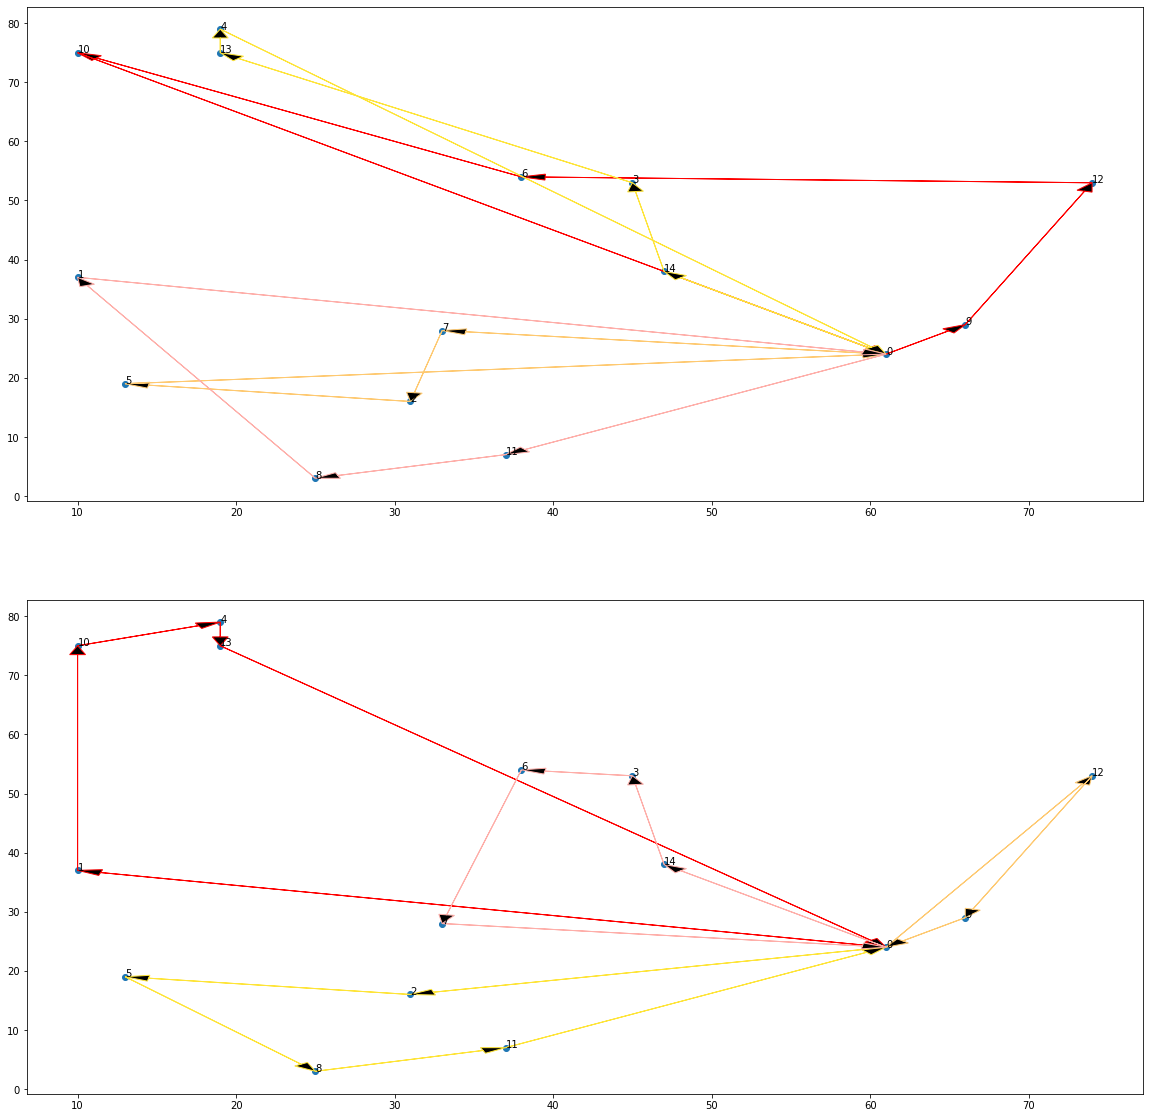

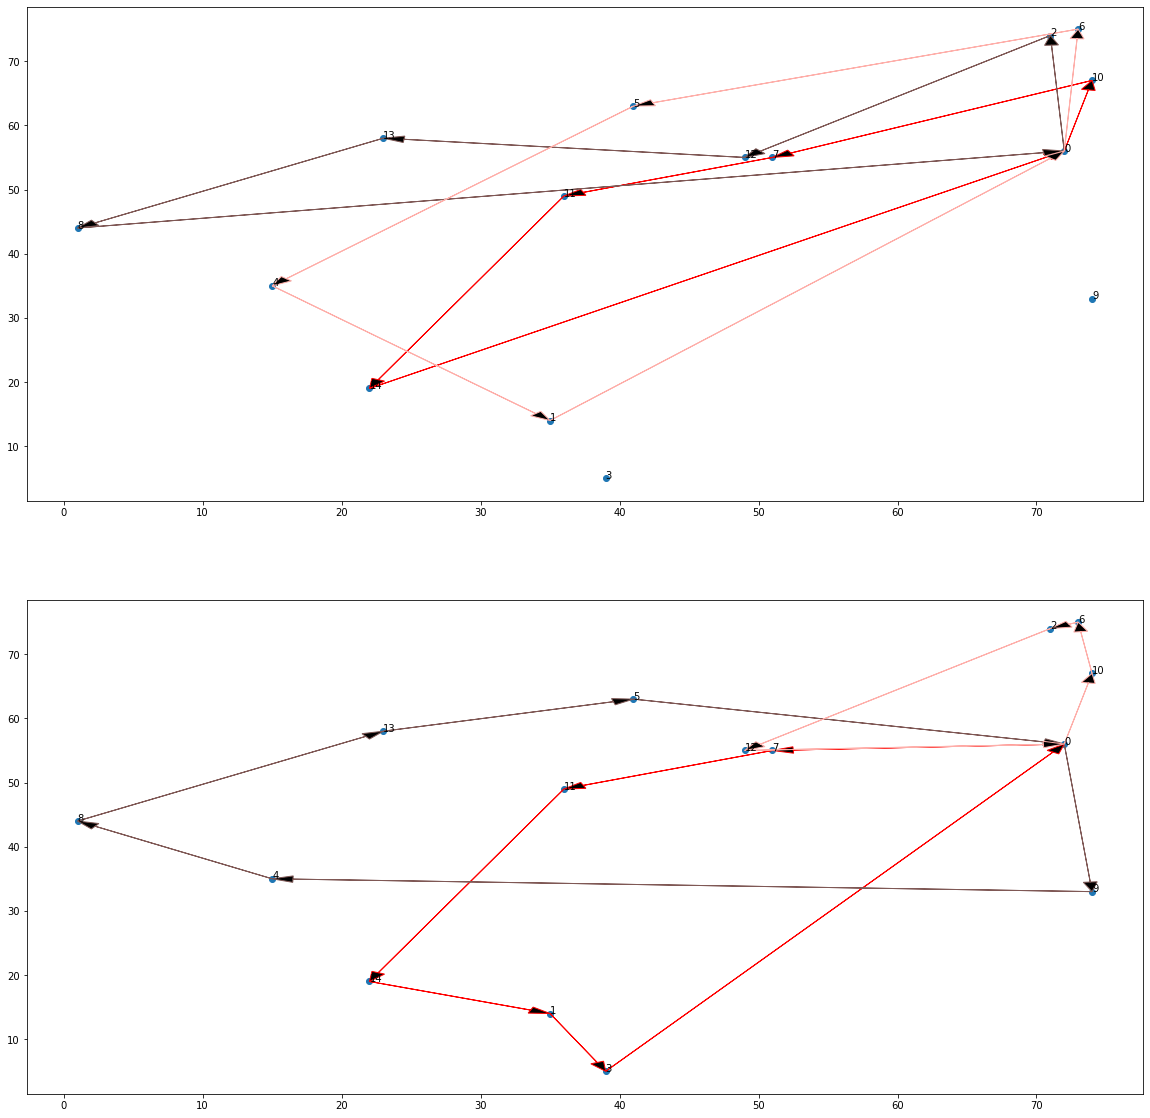

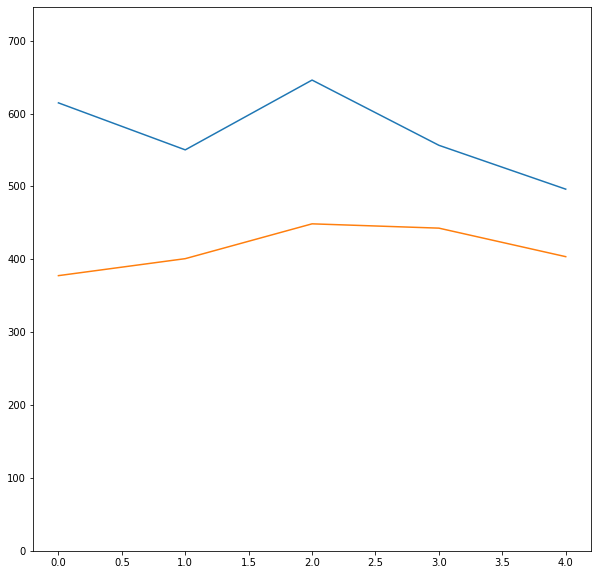

In [6]:
def draw_paths(fig, points, paths):
    Origin = []
    Destin = []
    
    fig.scatter(points[0,:], points[1,:])

    for i, label in enumerate(range(points.shape[1])):
        fig.annotate(label, (points[0,i], points[1,i]))

    colors = generate_n_colors(len(paths))
    for i, path in enumerate(paths):
        color = colors[i]
        for i in range(1, len(path)):
            arrow(fig, points[:, path[i - 1]], points[:, path[i]], color=color)

def solve(distances, demands, n_vehicles, max_capacity):
    inf_dist = max(max(row) for row in distances) + 1
    n_vertices = len(distances)
    heads = [0] * n_vehicles
    capacities = [max_capacity] * n_vehicles
    paths = [[0] for i in range(n_vehicles)]
    used = [False] * n_vertices
    used[0] = True
    end = n_vertices + 1
    n_finished = 0

    while n_finished != n_vehicles:
        for p, head in enumerate(heads):
            if head == end:
                continue
            min_dist = inf_dist
            best_neigh = end
            for neigh in range(n_vertices):
                if used[neigh]:
                    continue
                dist = distances[head][neigh]
                if capacities[p] > demands[neigh] and dist < min_dist:
                    min_dist = dist
                    best_neigh = neigh
            heads[p] = best_neigh
            if (best_neigh == end):
                n_finished += 1
                paths[p].append(0)
            else:
                paths[p].append(best_neigh)
                capacities[p] -= demands[best_neigh]
                used[best_neigh] = True
    return paths

def test(fig, test_size, Capacity):
    points, dists, demands = generate_test(test_size)
    fig.figure(figsize=(20,20))
    h_paths = solve(dists, demands, 1 + int(sum(demands) / Capacity), Capacity)
    real_paths = real_solve(dists, demands, 1 + int(sum(demands) / Capacity), test_size, Capacity)
#     real_paths = solve(dists, demands, 1 + int(sum(demands) / Capacity), Capacity)
    f = fig.subplot(2, 1, 1)
    draw_paths(f, points, h_paths)
    f2 = fig.subplot(2, 1, 2)
    draw_paths(f2, points, real_paths)
    return distances(h_paths, dists), distances(real_paths, dists)

results = []
for i in range(5):
    h, real = test(plt, 15, 20)
    results.append((h, real))

plt.figure(figsize=(10, 10))
plt.ylim(0, max(max(i) for i in results) + 100)
plt.plot(results)
    